<center><h1 class="list-group-item list-group-item-success"><font size = 6>Neural Image Caption Attention mechanism</font></h1></center><br>

In [2]:
#Import all the required libraries
!pip install wordcloud
!pip install gtts
!pip install playsound

     |████████████████████████████████| 62 kB 722 kB/s             
  Attempting uninstall: requests
    Found existing installation: requests 2.26.0
    Uninstalling requests-2.26.0:
      Successfully uninstalled requests-2.26.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
beatrix-jupyterlab 3.1.6 requires google-cloud-bigquery-storage, which is not installed.
spacy 3.2.2 requires typing-extensions<4.0.0.0,>=3.7.4; python_version < "3.8", but you have typing-extensions 4.1.1 which is incompatible.
gcsfs 2021.11.1 requires fsspec==2021.11.1, but you have fsspec 2022.2.0 which is incompatible.
apache-beam 2.34.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.4 which is incompatible.
apache-beam 2.34.0 requires httplib2<0.20.0,>=0.8, but you have httplib2 0.20.2 which is incompa

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import tensorflow as tf
import keras
from keras.preprocessing.image import load_img
import string
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Input
from PIL import Image
#used for creating Progress Meters or Progress Bars
from tqdm import tqdm

In [4]:
import glob
from gtts import gTTS
from playsound import playsound
from IPython import display
import collections
import wordcloud
from wordcloud import WordCloud, STOPWORDS

In [ ]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/content/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/flickr8k/captions.txt
/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg
/kaggle/input/flickr8k/Images/214543992_ce6c0d9f9b.jpg
/kaggle/input/flickr8k/Images/2366643786_9c9a830db8.jpg
/kaggle/input/flickr8k/Images/3368819708_0bfa0808f8.jpg
/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg
/kaggle/input/flickr8k/Images/2752809449_632cd991b3.jpg
/kaggle/input/flickr8k/Images/3097776588_312932e438.jpg
/kaggle/input/flickr8k/Images/1206506157_c7956accd5.jpg
/kaggle/input/flickr8k/Images/1319634306_816f21677f.jpg
/kaggle/input/flickr8k/Images/2465218087_fca77998c6.jpg
/kaggle/input/flickr8k/Images/3351493005_6e5030f596.jpg
/kaggle/input/flickr8k/Images/2949337912_beba55698b.jpg
/kaggle/input/flickr8k/Images/534886684_a6c9f40fa1.jpg
/kaggle/input/flickr8k/Images/3543600125_223747ef4c.jpg
/kaggle/input/flickr8k/Images/2174206711_11cb712a8d.jpg
/kaggle/input/flickr8k/Images/280706862_14c30d734a.jpg
/kaggle/input/flickr8k/Images/2100735137_05c6079537.jpg
/kaggle/input/f

 <h2> Data Understanding and Visualization
</h2><ul>

In [ ]:
images='/content/data/Images'
all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


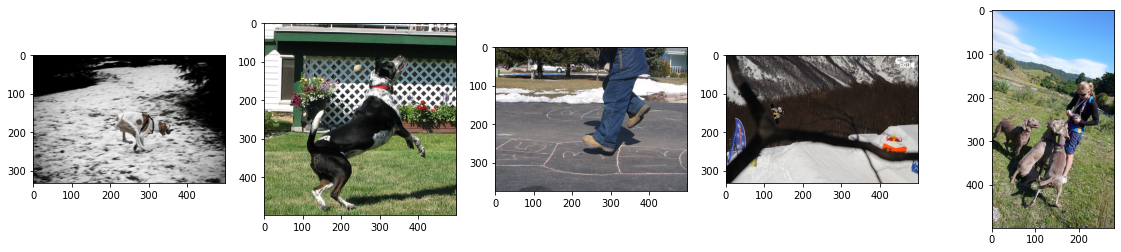

In [7]:
import imageio
#Visualising first 5 images :
Display_Images = all_imgs[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)
for ax, image in zip(axes, Display_Images):
  ax.imshow(imageio.imread(image), cmap=None)


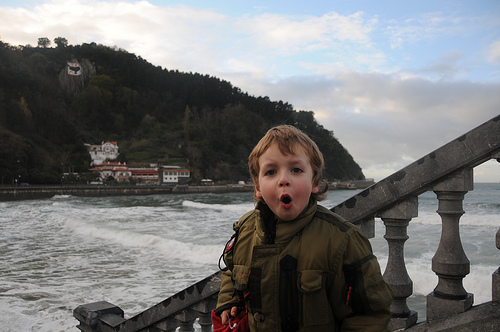

In [8]:
import random
Image.open(all_imgs[random.randrange(40, 60, 3)])# view a random image
import random
Image.open(all_imgs[random.randrange(40, 60, 3)])

In [ ]:
text_file = '/content/data/captions.txt'
def load_doc(filename):
    open_file = open(text_file, 'r', encoding='latin-1' ) 
    text = open_file.read() 
    open_file.close()
    return text
doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


In [ ]:
img_path = '/content/data/Images'

all_img_id = [] 
all_img_vector = [] 
annotations = [] 

with open('/content/data/captions.txt' , 'r') as fo:
  next(fo) 
  for line in fo :
    split_arr = line.split(',')
    all_img_id.append(split_arr[0])
    annotations.append(split_arr[1].rstrip('\n.')) #removing out the \n.
    all_img_vector.append(img_path+split_arr[0])

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

ID  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
40450   997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   

                                                    Path  \
0      /kaggle/input/flickr8k/Images/1000268201_693b0...   
1      /kaggle/input/flickr8k/Images/1000268201_693b0...   
2      /kaggle/input/flickr8k/Images/1000268201_693b0...   
3      /kaggle/input/flickr8k/Images/1000268201_693b0...   
4      /kaggle/input/flickr8k/Images/1000268201_693b0...   
...                                                  ...   
40450  /kaggle/input/flickr8k/Images/997722733_0cb543...   
40451  /kaggle/input/flickr8k/Images/997722733_0cb543...   
40452  /kaggle/input/flickr8k/Images/997722733_0cb543...   
40453  /kaggle/input/flickr8k/Images/997722733_0cb543...   
40454  /kaggle/input/flickr8k/Images/997722733_0cb543...   

                                                Captions  
0      A child in a pink dress is climbing up a set o...  
1                   A girl going into a wooden building   
2        A little girl climbing into a wooden playhouse   
3      A little girl climbing the stairs to her playh...  
4      A little girl in a pink dress going into a woo...  
...                                                  ...  
40450           A man in a pink shirt climbs a rock face  
40451            A man is rock climbing high in the air   
40452  A person in a red shirt climbing up a rock fac...  
40453                     A rock climber in a red shirt   
40454  A rock climber practices on a rock climbing wall   

[40455 rows x 3 columns]

In [11]:
#check total captions and images present in dataset
print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_imgs)))

Total captions present in the dataset: 40455
Total images present in the dataset: 8091


In [12]:
#Create the vocabulary & the counter for the captions
vocabulary = [word.lower() for line in annotations for word in line.split()]
val_count = Counter(vocabulary) 
val_count

Counter({'a': 60196,
         'child': 1507,
         'in': 18174,
         'pink': 702,
         'dress': 332,
         'is': 9069,
         'climbing': 490,
         'up': 1215,
         'set': 105,
         'of': 6495,
         'stairs': 109,
         'an': 2325,
         'entry': 1,
         'way': 48,
         'girl': 3277,
         'going': 145,
         'into': 1046,
         'wooden': 278,
         'building': 485,
         'little': 1736,
         'playhouse': 6,
         'the': 17507,
         'to': 3005,
         'her': 1102,
         'cabin': 4,
         'black': 3620,
         'dog': 7948,
         'and': 8057,
         'spotted': 36,
         'are': 3365,
         'fighting': 130,
         'tri-colored': 12,
         'playing': 1954,
         'with': 7304,
         'each': 399,
         'other': 667,
         'on': 10357,
         'road': 380,
         'white': 3706,
         'brown': 2457,
         'spots': 28,
         'staring': 57,
         'at': 2810,
         'stree

a :  60196
in :  18174
the :  17507
on :  10357
is :  9069
and :  8057
dog :  7948
with :  7304
man :  7137
of :  6495
two :  5132
white :  3706
black :  3620
boy :  3514
are :  3365
woman :  3304
girl :  3277
to :  3005
wearing :  2916
people :  2811
at :  2810
water :  2676
young :  2587
red :  2553
brown :  2457
an :  2325
his :  2255
blue :  2125
dogs :  2095
running :  1996


Text(0, 0.5, 'Count')

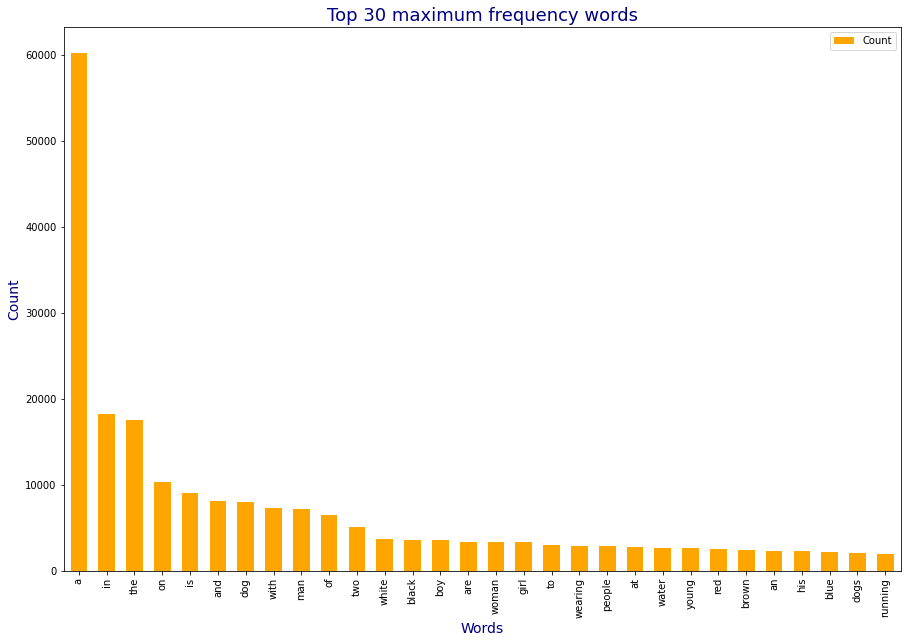

In [13]:
#Visualise the top 30 occuring words in the captions
for word, count in val_count.most_common(30):
  print(word, ": ", count)

lst = val_count.most_common(30)
most_common_words_df = pd.DataFrame(lst, columns = ['Word', 'Count'])
most_common_words_df.plot.bar(x='Word', y='Count', width=0.6, color='orange', figsize=(15, 10))
plt.title("Top 30 maximum frequency words", fontsize = 18, color= 'navy')
plt.xlabel("Words", fontsize = 14, color= 'navy')
plt.ylabel("Count", fontsize = 14, color= 'navy')


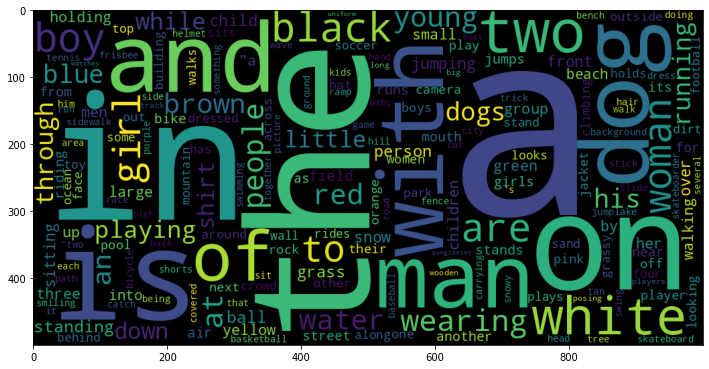

In [14]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(val_count)
plt.figure(figsize = (12, 12))
plt.imshow(wordcloud)

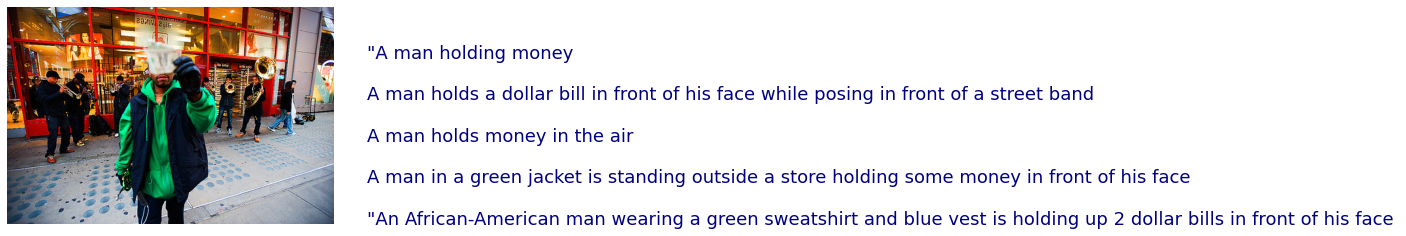

In [15]:
def caption_with_img_plot(image_id, frame) :
  capt = ("\n" *2).join(frame[frame['ID'] == image_id].Captions.to_list())
  fig, ax = plt.subplots()
  ax.set_axis_off()
  idx = df.ID.to_list().index(image_id)
  im =  Image.open(df.Path.iloc[idx])
  w, h = im.size[0], im.size[-1]
  ax.imshow(im)
  ax.text(w+50, h, capt, fontsize = 18, color = 'navy')
caption_with_img_plot(df.ID.iloc[8049], df)


 <h2> Clean Data
</h2><ul>

In [16]:
#data cleaning
rem_punct = str.maketrans('', '', string.punctuation)
for r in range(len(annotations)) :
  line = annotations[r]
  line = line.split()

  # converting to lowercase
  line = [word.lower() for word in line]

  # remove punctuation from each caption and hanging letters
  line = [word.translate(rem_punct) for word in line]
  line = [word for word in line if len(word) > 1]

  # remove numeric values
  line = [word for word in line if word.isalpha()]

  annotations[r] = ' '.join(line)


In [17]:
#add the <start> & <end> token to all those captions as well
annotations = ['<start>' + ' ' + line + ' ' + '<end>' for line in annotations]

#Create a list which contains all the path to the images
all_img_path = all_img_vector

In [18]:
##list contatining captions for an image
annotations[0:5]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

 <h2> Data Preprocessing</h2>
 <ul>

In [19]:
# Creating the tokenizer
top_word_cnt = 5000
tokenizer = Tokenizer(num_words = top_word_cnt+1, filters= '!"#$%^&*()_+.,:;-?/~`{}[]|\=@ ',
                      lower = True, char_level = False, 
                      oov_token = 'UNK')

In [20]:
# Creating word-to-index and index-to-word mappings.

tokenizer.fit_on_texts(annotations)
#transform each text into a sequence of integers
train_seqs = tokenizer.texts_to_sequences(annotations)

In [21]:
# We add PAD token for zero
tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

In [22]:
print(tokenizer.oov_token)
print(tokenizer.index_word[0])

UNK
PAD


In [23]:
tokenizer.index_word

{1: 'UNK',
 2: '<start>',
 3: '<end>',
 4: 'in',
 5: 'the',
 6: 'on',
 7: 'is',
 8: 'and',
 9: 'dog',
 10: 'with',
 11: 'man',
 12: 'of',
 13: 'two',
 14: 'white',
 15: 'black',
 16: 'boy',
 17: 'are',
 18: 'woman',
 19: 'girl',
 20: 'to',
 21: 'wearing',
 22: 'people',
 23: 'at',
 24: 'water',
 25: 'young',
 26: 'red',
 27: 'brown',
 28: 'an',
 29: 'his',
 30: 'blue',
 31: 'dogs',
 32: 'running',
 33: 'through',
 34: 'playing',
 35: 'while',
 36: 'down',
 37: 'little',
 38: 'shirt',
 39: 'standing',
 40: 'ball',
 41: 'grass',
 42: 'person',
 43: 'child',
 44: 'snow',
 45: 'jumping',
 46: 'over',
 47: 'three',
 48: 'front',
 49: 'sitting',
 50: 'small',
 51: 'field',
 52: 'up',
 53: 'holding',
 54: 'large',
 55: 'group',
 56: 'by',
 57: 'green',
 58: 'yellow',
 59: 'children',
 60: 'walking',
 61: 'men',
 62: 'her',
 63: 'into',
 64: 'beach',
 65: 'air',
 66: 'near',
 67: 'jumps',
 68: 'mouth',
 69: 'street',
 70: 'runs',
 71: 'for',
 72: 'another',
 73: 'riding',
 74: 'from',
 75: 'it

In [24]:
# Creating a word count for our tokenizer to visualize the Top 30 occuring words after text processing

tokenizer_top_words = [word for line in annotations for word in line.split() ]

#tokenizer_top_words_count
tokenizer_top_words_count = collections.Counter(tokenizer_top_words)


<start> :  40455
<end> :  40455
in :  18182
the :  17676
on :  10367
is :  9069
and :  8057
dog :  7956
with :  7308
man :  7164
of :  6496
two :  5546
white :  3710
black :  3627
boy :  3534
are :  3365
woman :  3320
girl :  3284
to :  3005
wearing :  2917
people :  2837
at :  2819
water :  2676
young :  2610
red :  2553
brown :  2471
an :  2358
his :  2255
blue :  2125
dogs :  2097


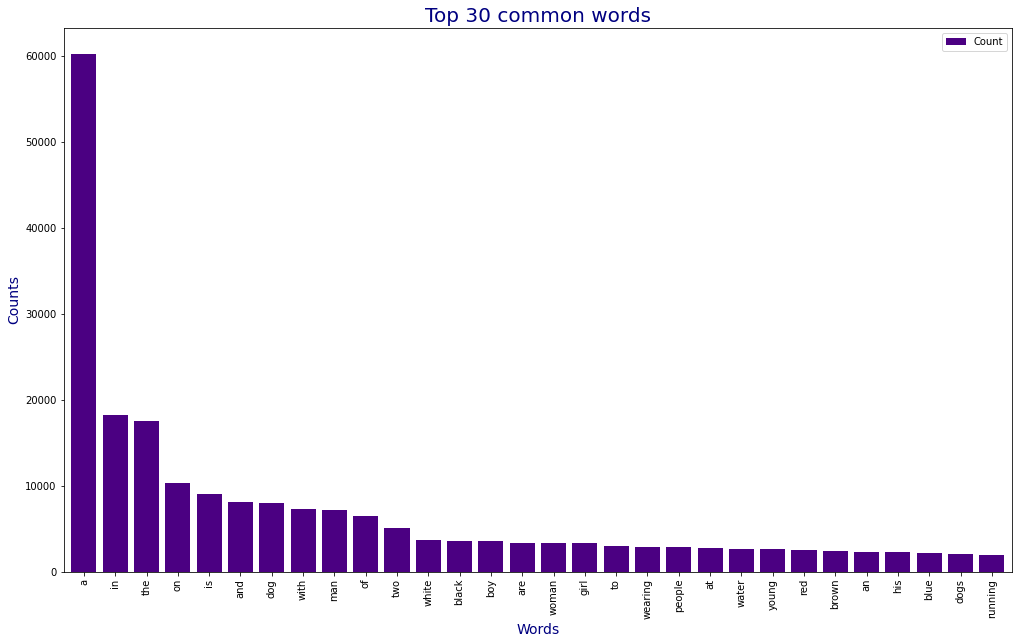

In [26]:
for word, count in tokenizer_top_words_count.most_common(30) :
  print(word, ": ", count)

tokens = tokenizer_top_words_count.most_common(30)
most_com_words_df = pd.DataFrame(tokens, columns = ['Word', 'Count'])

#plot 30 most common words
most_common_words_df.plot.bar(x = 'Word', y= 'Count', width=0.8, color = 'indigo', figsize = (17, 10))
plt.title('Top 30 common words', fontsize =20, color= 'navy')
plt.xlabel('Words', fontsize =14, color= 'navy')
plt.ylabel('Counts', fontsize =14, color= 'navy')
plt.grid(False)

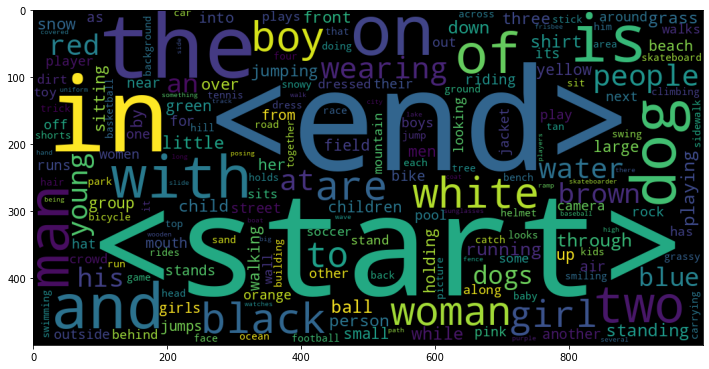

In [27]:
wordcloud_token = WordCloud(width = 1000, height = 500).generate_from_frequencies(tokenizer_top_words_count)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud_token)
plt.grid(False)

In [28]:
# Pad each vector to the max_length of the captions  store it to a vairable

train_seqs_len = [len(seq) for seq in train_seqs]

longest_word_length = max(train_seqs_len)

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding= 'post', maxlen = longest_word_length,
                                                          dtype='int32', value=0)
print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 31)


In [29]:
# creating list to store preprocessed images and setting up the Image Shape

preprocessed_image = []
IMAGE_SHAPE = (299, 299)

In [30]:
#checking image format 
tf.keras.backend.image_data_format()

'channels_last'

In [31]:
for img in all_imgs[0:5] :
    img = tf.io.read_file(img, name=None)
    img = tf.image.decode_jpeg(img, channels=0)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    preprocessed_image.append(img)

Shape after resize :  (299, 299, 3)
Shape after resize :  (299, 299, 3)
Shape after resize :  (299, 299, 3)
Shape after resize :  (299, 299, 3)
Shape after resize :  (299, 299, 3)


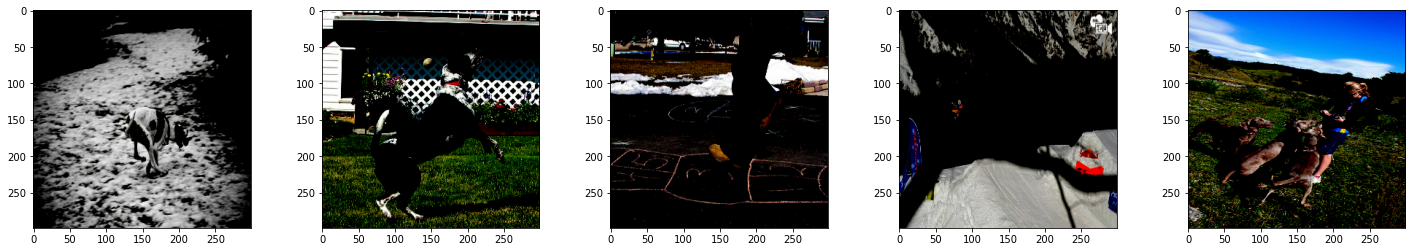

In [33]:
# checking first five images post preprocessing
Display_Images = preprocessed_image[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(25)
for ax, image in zip(axes, Display_Images) :
  print('Shape after resize : ', image.shape)
  ax.imshow(image)
  ax.grid(False)

 <h2>  Dataset creation
</h2>






In [34]:
def load_images(image_path) :
  img = tf.io.read_file(image_path, name = None)
  img = tf.image.decode_jpeg(img, channels=0)
  img = tf.image.resize(img, IMAGE_SHAPE)
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path

In [35]:
all_img_vector

['/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
 '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
 '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
 '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
 '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
 '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
 '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
 '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
 '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
 '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
 '/kaggle/input/flickr8k/Images/1002674143_1b742ab4b8.jpg',
 '/kaggle/input/flickr8k/Images/1002674143_1b742ab4b8.jpg',
 '/kaggle/input/flickr8k/Images/1002674143_1b742ab4b8.jpg',
 '/kaggle/input/flickr8k/Images/1002674143_1b742ab4b8.jpg',
 '/kaggle/input/flickr8k/Images/1002674143_1b742ab4b8.jpg',
 '/kaggle/input/flickr8k/Images/1003163366_44323f5815.jpg',
 '/kaggle/input/flickr8k/Images/10031633

In [36]:
# Map each image full path to the function, in order to preprocess the image
training_list = sorted(set(all_img_vector))
New_Img = tf.data.Dataset.from_tensor_slices(training_list)
New_Img = New_Img.map(load_images, num_parallel_calls = tf.data.experimental.AUTOTUNE)
New_Img = New_Img.batch(64, drop_remainder=False)

In [37]:
#Ratio = 80:20 and we will set random state = 42
path_train, path_test, caption_train, caption_test = train_test_split(all_img_vector, cap_vector, test_size = 0.2, random_state = 42)

In [38]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(caption_train)))
print("Testing data for Captions: " + str(len(caption_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


 <h2> Load the pretrained Imagenet weights of Inception net V3
</h2>  

In [39]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
new_input = image_model.input 
hidden_layer = image_model.layers[-1].output  
image_features_extract_model = tf.compat.v1.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 1s 0us/step


In [40]:
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [41]:
# extract features from each image in the dataset
img_features = {}
for image, image_path in tqdm(New_Img) :
  batch_features = image_features_extract_model(image)
  #squeeze out the features in a batch
  batch_features_flattened = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
  for batch_feat, path in zip(batch_features_flattened, image_path) :
    feature_path = path.numpy().decode('utf-8')
    img_features[feature_path] = batch_feat.numpy()

100%|██████████| 127/127 [00:36<00:00,  3.43it/s]


In [42]:
batch_features

<tf.Tensor: shape=(27, 8, 8, 2048), dtype=float32, numpy=
array([[[[0.00000000e+00, 7.73590952e-02, 0.00000000e+00, ...,
          2.31990203e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.07845321e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.94018483e-01, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 1.85825527e-01],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          9.42283124e-02, 0.00000000e+00, 5.05860507e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 4.23104107e-01, 1.33328093e-02, ...,
          2.33793616e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         

In [43]:
batch_features_flattened

<tf.Tensor: shape=(27, 64, 2048), dtype=float32, numpy=
array([[[0.0000000e+00, 7.7359095e-02, 0.0000000e+00, ...,
         2.3199020e-01, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.0784532e-01, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 1.9401848e-01, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 1.8582553e-01],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 1.6567849e+00, 0.0000000e+00],
        [0.0000000e+00, 4.0278664e-01, 0.0000000e+00, ...,
         0.0000000e+00, 3.1788370e-01, 0.0000000e+00],
        [0.0000000e+00, 2.5347657e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.2506980e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 7.8535922e-02, ...,
         1.2066435e+00, 0.0000000e+00, 0.0000000e+00],
        [0.000000

In [44]:
batch_feat.shape

TensorShape([64, 2048])

In [45]:
#view top five items of img_features dict
import more_itertools
top_5 = more_itertools.take(5, img_features.items())
top_5

[('/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
  array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.1699807 ],
         [0.        , 0.        , 1.0105209 , ..., 0.        , 0.        ,
          0.06119432],
         ...,
         [0.        , 0.        , 2.0380137 , ..., 1.2030448 , 0.        ,
          1.992843  ],
         [0.        , 0.        , 0.904673  , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 1.2529943 , 0.        , ..., 0.        , 0.        ,
          0.        ]], dtype=float32)),
 ('/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
  array([[0.        , 0.66376555, 0.46287003, ..., 0.        , 0.        ,
          3.3321111 ],
         [0.        , 1.2268165 , 0.        , ..., 0.        , 0.25420666,
          3.3293478 ],
         [1.2878606 , 1.5197304 , 0.        , ..., 0.4678154 ,

In [46]:
#to provide, both images along with the captions as input
def map(image_name, caption):
    img_tensor = img_features[image_name.decode('utf-8')]
    return img_tensor, caption

In [47]:
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
BUFFER_SIZE = 1000
BATCH_SIZE = 64
def gen_dataset(img, capt):
        
    data = tf.data.Dataset.from_tensor_slices((img, capt))
    data = data.map(lambda ele1, ele2 : tf.numpy_function(map, [ele1, ele2], [tf.float32, tf.int32]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE)
    
     
    data = (data.shuffle(BUFFER_SIZE, reshuffle_each_iteration= True).batch(BATCH_SIZE, drop_remainder = False)
    .prefetch(tf.data.experimental.AUTOTUNE))
    return data

In [48]:
train_dataset = gen_dataset(path_train,caption_train)
test_dataset = gen_dataset(path_test,caption_test)

In [49]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 31)


<h2> Model Building</h2>

In [50]:
# Setting  parameters

embedding_dim = 256 
units = 512

#top 5,000 words +1
vocab_size = 5001
train_num_steps = len(path_train) // BATCH_SIZE 
test_num_steps = len(path_test) // BATCH_SIZE  

max_length = 31
feature_shape = batch_feat.shape[1]
attention_feature_shape = batch_feat.shape[0]

 <h2>  Encoder (CNN)
</h2>

In [51]:
tf.compat.v1.reset_default_graph()
print(tf.compat.v1.get_default_graph())

In [52]:
#Building Encoder using CNN Keras subclassing method

class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim) #build your Dense layer with relu activation
        
    def call(self, features):
        features =  self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0)
        return features

In [53]:
encoder=Encoder(embedding_dim)

In [54]:
from keras.utils.vis_utils import plot_model



 <h2> Important aspects of Encoder
</h2>


 <h2> Attention model
</h2>

In [55]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) 
        self.W2 = tf.keras.layers.Dense(units) 
        self.V = tf.keras.layers.Dense(1) 
        self.units=units

    def call(self, features, hidden):
        hidden_with_time_axis = hidden[:, tf.newaxis]
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))  
        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1) 
        context_vector = attention_weights * features 
        context_vector = tf.reduce_sum(context_vector, axis=1)  
        return context_vector, attention_weights

 <h2> Decoder </h2>

In [56]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [57]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [58]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


 <h2> Model training & optimization
</h2>

In [59]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)  #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE) #define your loss object

In [60]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    #loss is getting multiplied with mask to get an ideal shape
    
    return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "/content/data/checkpoint1"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [62]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [63]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        
        encoder_op = encoder(img_tensor)
        for r in range(1, target.shape[1]) :
          predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
          loss = loss + loss_function(target[:, r], predictions) 
          dec_input = tf.expand_dims(target[:, r], 1)  

    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars) 
    optimizer.apply_gradients(zip(grad, trainable_vars))

    return loss, avg_loss

In [64]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size = target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
      encoder_op = encoder(img_tensor)
      for r in range(1, target.shape[1]) :
        predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
        loss = loss + loss_function(target[:, r], predictions)
        dec_input = tf.expand_dims(target[: , r], 1)
    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars) 
    optimizer.apply_gradients(zip(grad, trainable_vars))                      
    return loss, avg_loss

In [65]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset) :
      batch_loss, t_loss = test_step(img_tensor, target)
      total_loss = total_loss + t_loss
      avg_test_loss = total_loss/ test_num_steps

    return avg_test_loss

In [66]:
loss_plot = []
test_loss_plot = []
EPOCHS = 30
best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps   
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/30 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.443, & test loss is 1.208
Time taken for 1 epoch 172.26163935661316 sec

Test loss has been reduced from 100.000 to 1.208


  7%|▋         | 2/30 [04:02<52:15, 111.98s/it]  

For epoch: 2, the train loss is 1.113, & test loss is 1.059
Time taken for 1 epoch 69.45164847373962 sec

Test loss has been reduced from 1.208 to 1.059


 10%|█         | 3/30 [05:11<41:41, 92.64s/it] 

For epoch: 3, the train loss is 1.007, & test loss is 0.975
Time taken for 1 epoch 69.49603247642517 sec

Test loss has been reduced from 1.059 to 0.975


 13%|█▎        | 4/30 [06:21<36:09, 83.43s/it]

For epoch: 4, the train loss is 0.934, & test loss is 0.908
Time taken for 1 epoch 69.16021466255188 sec

Test loss has been reduced from 0.975 to 0.908


 17%|█▋        | 5/30 [07:30<32:38, 78.36s/it]

For epoch: 5, the train loss is 0.874, & test loss is 0.850
Time taken for 1 epoch 69.24006366729736 sec

Test loss has been reduced from 0.908 to 0.850


 20%|██        | 6/30 [08:40<30:09, 75.40s/it]

For epoch: 6, the train loss is 0.822, & test loss is 0.803
Time taken for 1 epoch 69.4841136932373 sec

Test loss has been reduced from 0.850 to 0.803


 23%|██▎       | 7/30 [09:49<28:09, 73.44s/it]

For epoch: 7, the train loss is 0.775, & test loss is 0.755
Time taken for 1 epoch 69.25641059875488 sec

Test loss has been reduced from 0.803 to 0.755


 27%|██▋       | 8/30 [10:58<26:25, 72.07s/it]

For epoch: 8, the train loss is 0.730, & test loss is 0.712
Time taken for 1 epoch 68.9755380153656 sec

Test loss has been reduced from 0.755 to 0.712


 30%|███       | 9/30 [12:07<24:54, 71.16s/it]

For epoch: 9, the train loss is 0.690, & test loss is 0.672
Time taken for 1 epoch 69.00899410247803 sec

Test loss has been reduced from 0.712 to 0.672


 33%|███▎      | 10/30 [13:17<23:32, 70.61s/it]

For epoch: 10, the train loss is 0.652, & test loss is 0.633
Time taken for 1 epoch 69.21015477180481 sec

Test loss has been reduced from 0.672 to 0.633


 37%|███▋      | 11/30 [14:27<22:17, 70.40s/it]

For epoch: 11, the train loss is 0.617, & test loss is 0.600
Time taken for 1 epoch 69.75616931915283 sec

Test loss has been reduced from 0.633 to 0.600


 40%|████      | 12/30 [15:36<21:02, 70.12s/it]

For epoch: 12, the train loss is 0.585, & test loss is 0.569
Time taken for 1 epoch 69.32908964157104 sec

Test loss has been reduced from 0.600 to 0.569


 43%|████▎     | 13/30 [16:45<19:47, 69.85s/it]

For epoch: 13, the train loss is 0.555, & test loss is 0.538
Time taken for 1 epoch 69.06467890739441 sec

Test loss has been reduced from 0.569 to 0.538


 47%|████▋     | 14/30 [17:54<18:33, 69.58s/it]

For epoch: 14, the train loss is 0.528, & test loss is 0.511
Time taken for 1 epoch 68.80854082107544 sec

Test loss has been reduced from 0.538 to 0.511


 50%|█████     | 15/30 [19:04<17:22, 69.49s/it]

For epoch: 15, the train loss is 0.502, & test loss is 0.487
Time taken for 1 epoch 69.12008380889893 sec

Test loss has been reduced from 0.511 to 0.487


 53%|█████▎    | 16/30 [20:13<16:11, 69.42s/it]

For epoch: 16, the train loss is 0.478, & test loss is 0.465
Time taken for 1 epoch 69.11122870445251 sec

Test loss has been reduced from 0.487 to 0.465


 57%|█████▋    | 17/30 [21:22<15:01, 69.37s/it]

For epoch: 17, the train loss is 0.457, & test loss is 0.442
Time taken for 1 epoch 69.06534171104431 sec

Test loss has been reduced from 0.465 to 0.442


 60%|██████    | 18/30 [22:31<13:51, 69.32s/it]

For epoch: 18, the train loss is 0.437, & test loss is 0.425
Time taken for 1 epoch 69.0498571395874 sec

Test loss has been reduced from 0.442 to 0.425


 63%|██████▎   | 19/30 [23:40<12:41, 69.26s/it]

For epoch: 19, the train loss is 0.419, & test loss is 0.408
Time taken for 1 epoch 68.97018218040466 sec

Test loss has been reduced from 0.425 to 0.408


 67%|██████▋   | 20/30 [24:49<11:32, 69.22s/it]

For epoch: 20, the train loss is 0.401, & test loss is 0.389
Time taken for 1 epoch 68.95331645011902 sec

Test loss has been reduced from 0.408 to 0.389


 70%|███████   | 21/30 [25:58<10:22, 69.12s/it]

For epoch: 21, the train loss is 0.387, & test loss is 0.376
Time taken for 1 epoch 68.73509526252747 sec

Test loss has been reduced from 0.389 to 0.376


 73%|███████▎  | 22/30 [27:08<09:13, 69.13s/it]

For epoch: 22, the train loss is 0.371, & test loss is 0.362
Time taken for 1 epoch 68.99423146247864 sec

Test loss has been reduced from 0.376 to 0.362


 77%|███████▋  | 23/30 [28:17<08:03, 69.13s/it]

For epoch: 23, the train loss is 0.359, & test loss is 0.351
Time taken for 1 epoch 68.9709825515747 sec

Test loss has been reduced from 0.362 to 0.351


 80%|████████  | 24/30 [29:26<06:54, 69.08s/it]

For epoch: 24, the train loss is 0.345, & test loss is 0.340
Time taken for 1 epoch 68.8190610408783 sec

Test loss has been reduced from 0.351 to 0.340


 83%|████████▎ | 25/30 [31:02<06:25, 77.17s/it]

For epoch: 25, the train loss is 0.335, & test loss is 0.325
Time taken for 1 epoch 95.88723969459534 sec

Test loss has been reduced from 0.340 to 0.325


 87%|████████▋ | 26/30 [32:11<04:59, 74.76s/it]

For epoch: 26, the train loss is 0.323, & test loss is 0.315
Time taken for 1 epoch 68.96815156936646 sec

Test loss has been reduced from 0.325 to 0.315


 90%|█████████ | 27/30 [33:20<03:39, 73.01s/it]

For epoch: 27, the train loss is 0.316, & test loss is 0.311
Time taken for 1 epoch 68.75522255897522 sec

Test loss has been reduced from 0.315 to 0.311


 93%|█████████▎| 28/30 [34:29<02:23, 71.86s/it]

For epoch: 28, the train loss is 0.305, & test loss is 0.296
Time taken for 1 epoch 69.02894711494446 sec

Test loss has been reduced from 0.311 to 0.296


 97%|█████████▋| 29/30 [35:38<01:11, 71.08s/it]

For epoch: 29, the train loss is 0.294, & test loss is 0.288
Time taken for 1 epoch 69.06867289543152 sec

Test loss has been reduced from 0.296 to 0.288


100%|██████████| 30/30 [36:47<00:00, 73.59s/it]

For epoch: 30, the train loss is 0.289, & test loss is 0.284
Time taken for 1 epoch 68.8828194141388 sec

Test loss has been reduced from 0.288 to 0.284


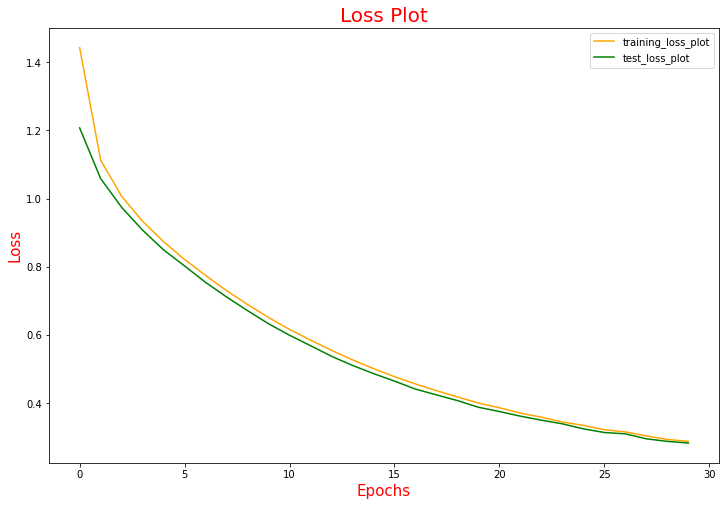

In [67]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8))
plt.plot(loss_plot, color='orange', label = 'training_loss_plot')
plt.plot(test_loss_plot, color='green', label = 'test_loss_plot')
plt.xlabel('Epochs', fontsize = 15, color = 'red')
plt.ylabel('Loss', fontsize = 15, color = 'red')
plt.title('Loss Plot', fontsize = 20, color = 'red')
plt.legend()
plt.show()


<h2>Model Evaluation</h2> 

<h4>Greedy Search</h4>

In [68]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_feature_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_images(image)[0], 0) 
    img_tensor_val = image_features_extract_model(temp_input) 
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder (img_tensor_val) 

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) 
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy() 
        result.append (tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


In [69]:
def plot_attention_map (caption, weights, image) :

  fig = plt.figure(figsize = (20, 20))
  temp_img = np.array(Image.open(image))

  cap_len = len(caption)
  for cap in range(cap_len) :
    weights_img = np.reshape(weights[cap], (8,8))
    wweights_img = np.array(Image.fromarray(weights_img).resize((224,224), Image.LANCZOS))

    ax = fig.add_subplot(cap_len//2, cap_len//2, cap+1)
    ax.set_title(caption[cap], fontsize = 14, color = 'red')

    img = ax.imshow(temp_img)

    ax.imshow(weights_img, cmap='gist_heat', alpha=0.6, extent=img.get_extent())
    ax.axis('off')
  plt.subplots_adjust(hspace=0.2, wspace=0.2)
  plt.show()

In [70]:
from nltk.translate.bleu_score import sentence_bleu

In [71]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [72]:
image_test = path_test.copy()

In [73]:
def pred_caption_audio(random, autoplay=False, weights=(0.5, 0.5, 0, 0)) :

    cap_test_data = caption_test.copy()
    rid = np.random.randint(0, random)
    test_image = image_test[rid]
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[rid] if i not in [0]])
    result, attention_plot, pred_test = evaluate(test_image)
    real_caption=filt_text(real_caption)      
    pred_caption=' '.join(result).rsplit(' ', 1)[0]
    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()
    score = sentence_bleu(reference, candidate, weights=weights)#set your weights
    print(f"BLEU score: {score*100}")
    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
    plot_attention_map(result, attention_plot, test_image)
    speech = gTTS('Predicted Caption : ' + pred_caption, lang = 'en', slow = False)
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'

    display.display(display.Audio(audio_file, rate = None, autoplay = autoplay))

    return test_image
    


 <h2> Test Images
</h2>

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score: 19.049194554039545
Real Caption: child at the edge of the water coming in on beach
Prediction Caption: woman runs along the beach


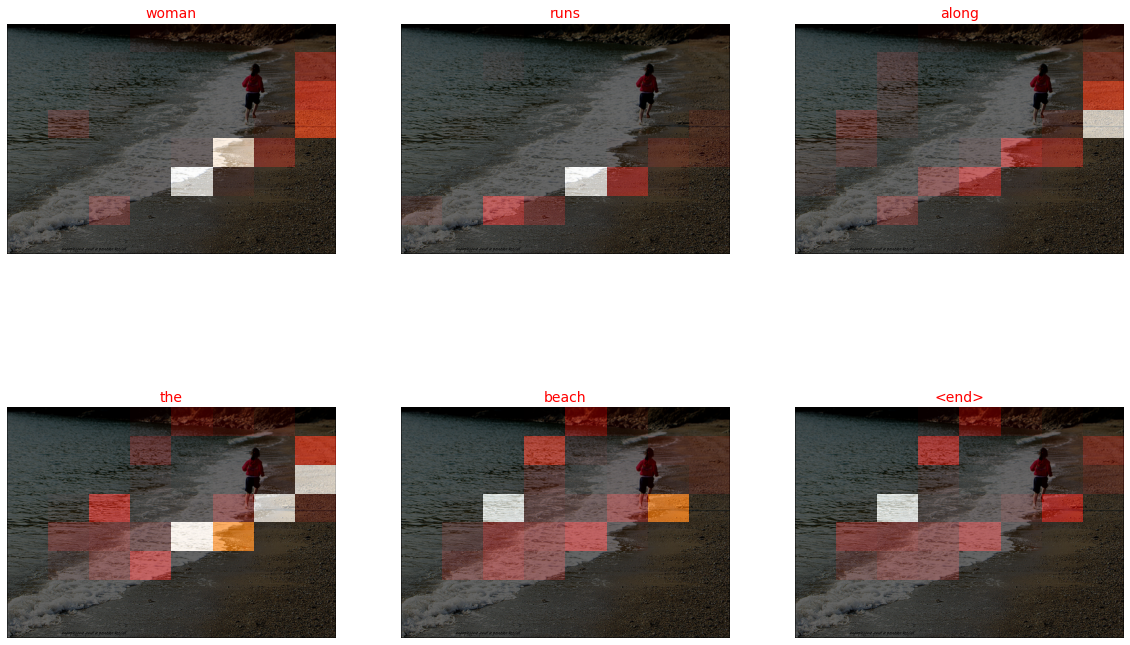

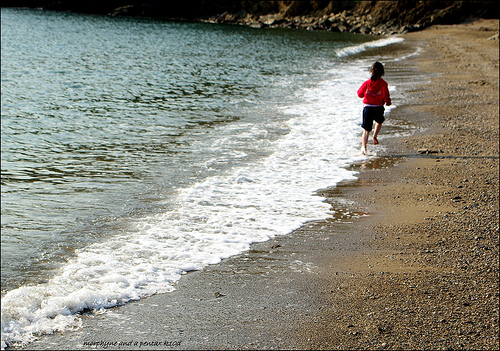

In [74]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.5, 0.25, 0, 0))
Image.open(test_image)

BLEU score: 32.40863609773656
Real Caption: woman and two men wearing hats and UNK are standing under avrovulcancom sign
Prediction Caption: woman and two men wearing black jackets


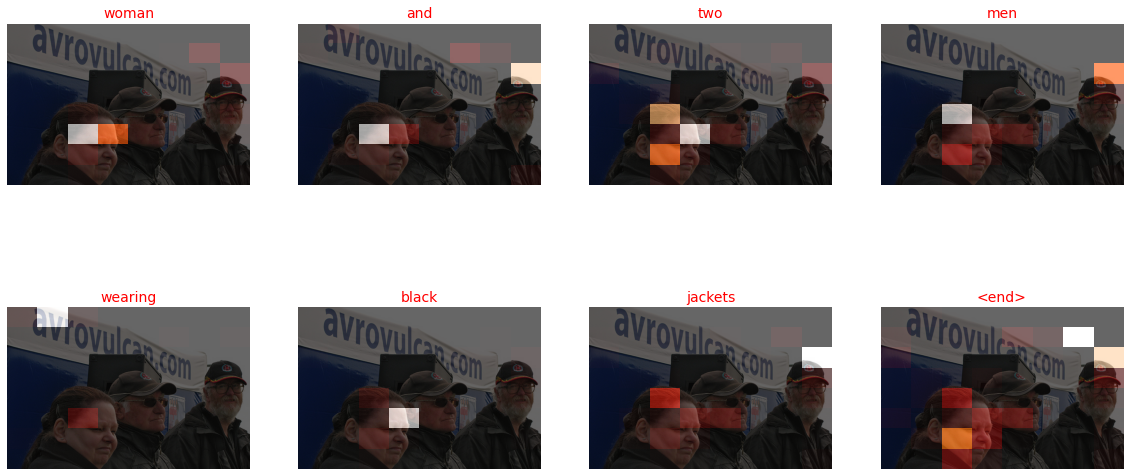

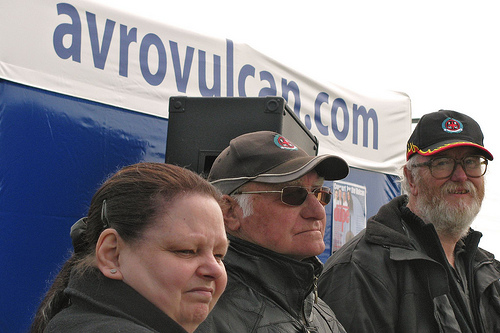

In [75]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.5, 0.25, 0, 0))
Image.open(test_image)

BLEU score: 48.894324242751566
Real Caption: kid in red falls as he struggles with kid in white to get to soccer ball
Prediction Caption: kid in red falls as he struggles with the ball


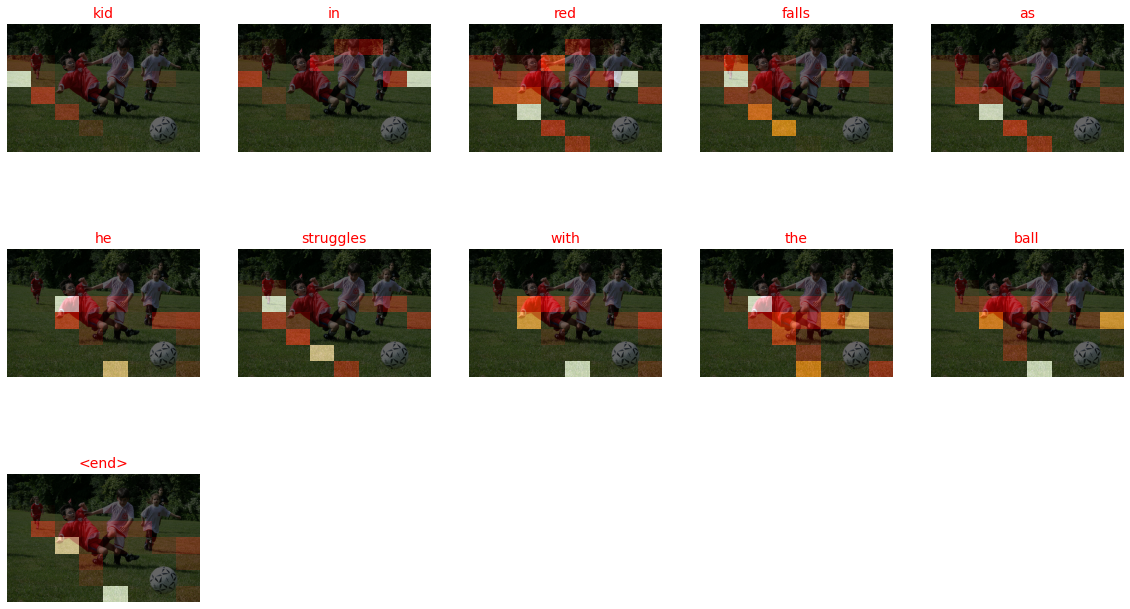

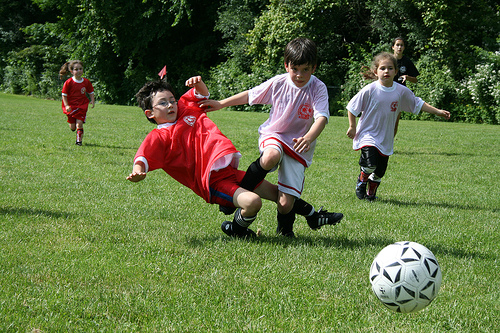

In [76]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.5, 0.25, 0, 0))
Image.open(test_image)

BLEU score: 100.0
Real Caption: muddy dog prances through the grass
Prediction Caption: muddy dog prances through the grass


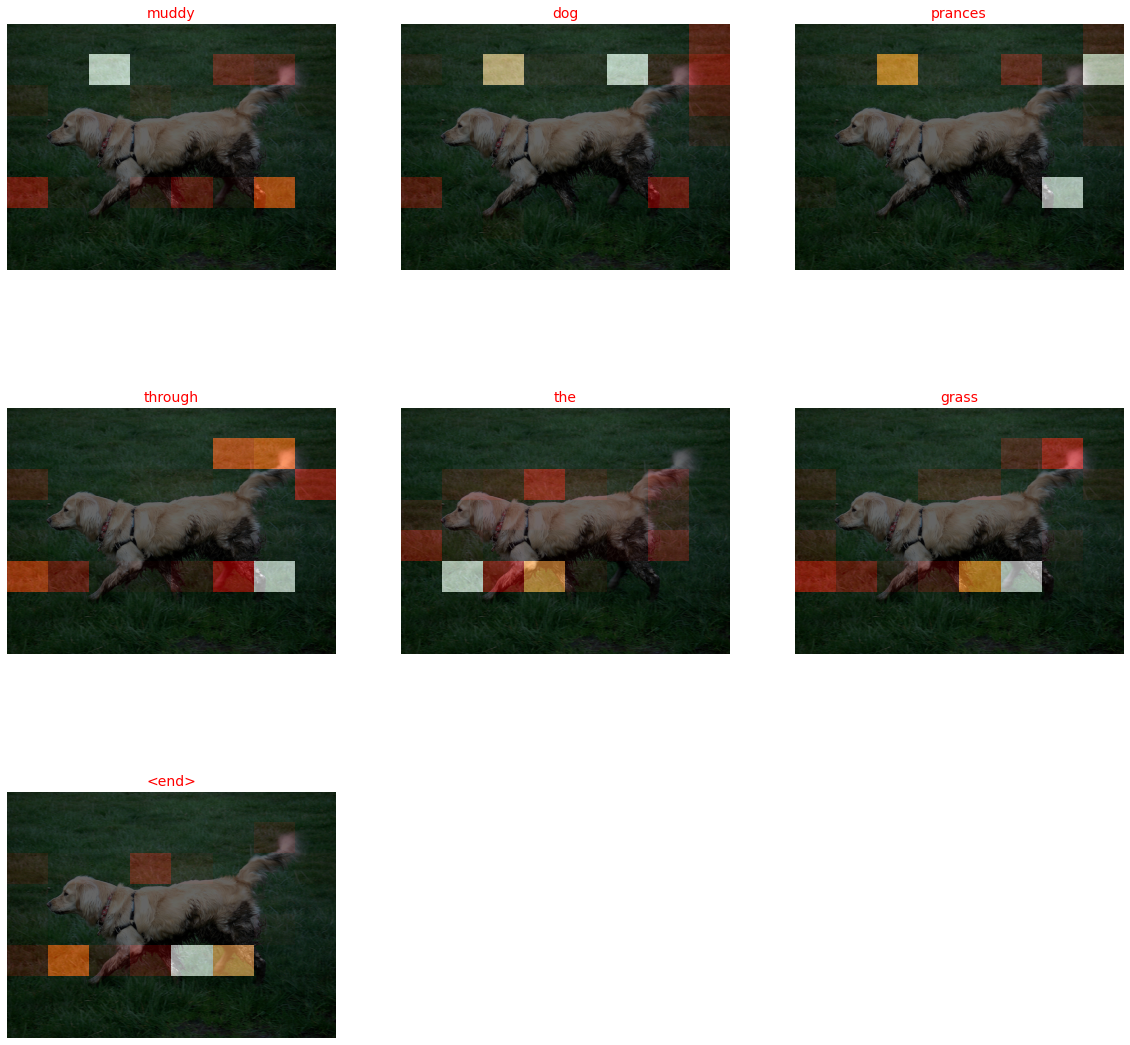

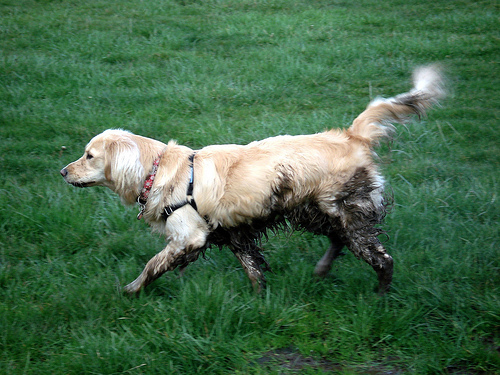

In [77]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.5, 0.5, 0, 0))
Image.open(test_image)

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score: 63.245553203367585
Real Caption: children playing in fountain
Prediction Caption: children are playing in fountain


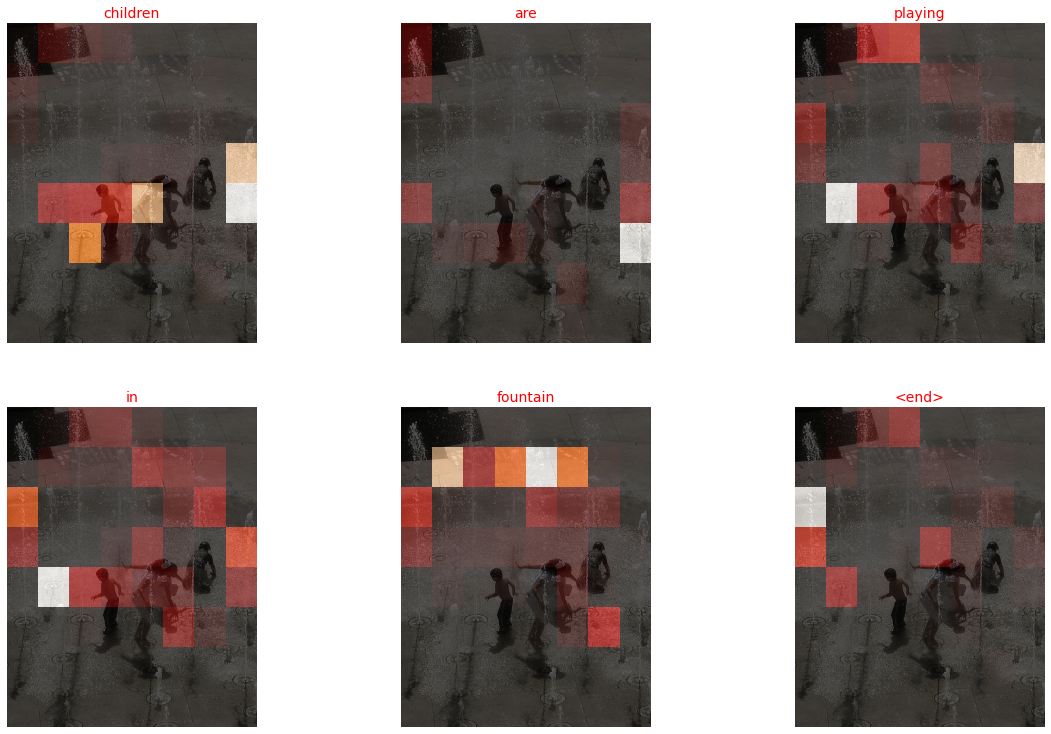

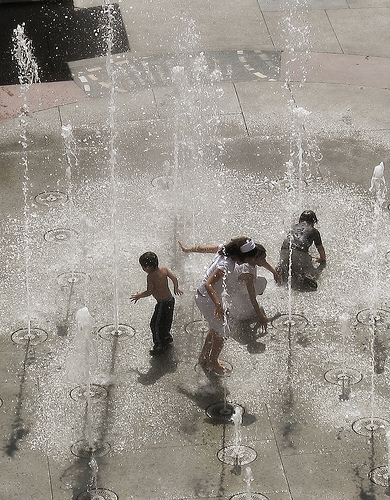

In [78]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.5, 0.5, 0, 0))
Image.open(test_image)

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score: 42.728700639623405
Real Caption: three dogs run in the snow
Prediction Caption: three dogs are turning direction along snow with red snow


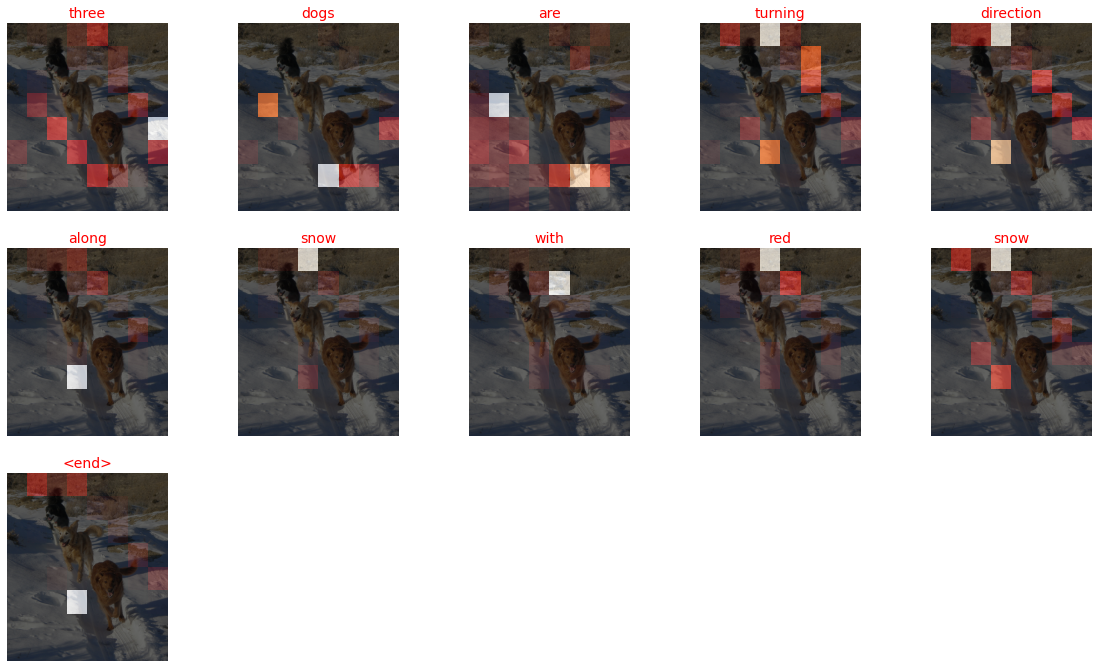

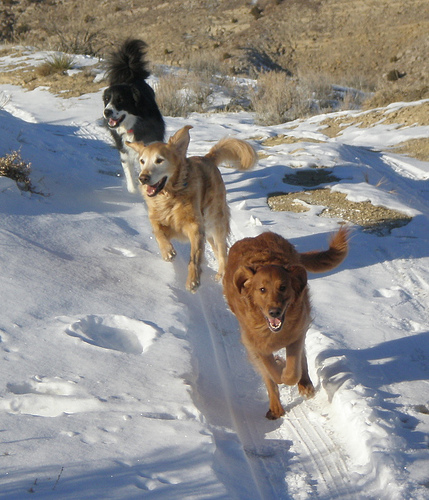

In [79]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.25, 0.25, 0, 0))
Image.open(test_image)

In [80]:
encoder.save_weights('./outputs_encoder')
decoder.save_weights('./outputs_decoder')